    MAP EXPLANATION
    The map is 10 x 10 grid with a starting position (0,0) and an ending position (0,9). A State is
    the cell in the map where the agent is currently positioned at. One episode ends when the
    agent reaches the final destination (Iron Throne) or when the maximum number of steps is
    reached.
    
Daenerys: The agent (starting position 0,0) can move up, down, right, left but cannot move outside of the grid!

Iron Throne: The goal where the episode ends (ending position 0,9). +100 reward.

Easy paths: Areas where Daenerys gains more power through allies. +1 reward.

Hard paths: Areas where Daenerys loses power because of hostile activities. -1 reward

Lannister army: -10 reward


In [13]:
import random
import numpy as np
import math
from matplotlib import pyplot as plt


from random import randint


class qlearner:

    def print_map(self, map):
        print("----------------------------------------------------")
        for i in range(len(map)):
            print(map[i])
        print("----------------------------------------------------")

    def __init__(self, debug) -> None:  # constructor
        self.current_pos = [0, 0]  # initialize start position
        # initialize reward map
        self.reward_map = [
            [-1, 1, 1, -10, -10, -10, -10, -10, 1, 100],
            [-1, -1, 1, -10, -10, -10, -10, -10, 1, -1],
            [-1, -1, 1, -10, -10, -10, -10, -10, 1, -1],
            [-1, -1, 1, 1, 1, -10, -10, -10, 1, -1],
            [-1, -1, 1, -1, 1, -10, -10, -10, 1, -1],
            [-1, -1, 1, -1, 1, -10, -10, -10, 1, -1],
            [-1, -1, 1, -1, 1, 1, 1, 1, 1, -1],
            [-1, -1, 1, -1, -1, -1, -1, -1, -1, -1],
            [-1, -10, 1, -10, -1, -1, -1, -1, -1, -1],
            [-1, -10, -10, -10, -1, -1, -1, -1, -1, -1]
        ]

        # map action words to intigers
        self.actions = {'up': 0, 'down': 1, 'left': 2, 'right': 3}
        self.actions_int_to_literal = {
            0: 'up', 1: 'down', 2: 'left', 3: 'right'}

        # initialize states as tuple to single integer mapping
        self.states = {}
        self. n = 10  # number of side squares
        k = 0
        for i in range(self. n):
            for j in range(self. n):
                self.states[(i, j)] = k
                k += 1

        self.Q = np.zeros((self.n*self.n, 4))  # total squares and 4 actions
        self.rewards_per_episode = [] #save rewards per episode
        self.moves_per_episode = [] #save moves per episode
        self.epsilon_per_episode = [] #save epsilon per episode
        self.debug = debug
        self.visited_positions = [] #save visited positions of last episode

    def run_q_learning(self, learning_rate, gamma,
                       epsilon_decay_rate, episodes, max_steps, epsilon):

        alpha = learning_rate  # alpha is the learning rate
        # total squares = n*n
        # need to initialize  Q with zeroes
        self.Q = np.zeros((self.n*self.n, 4))  # total squares and 4 actions
        terminal_state = [9]  # terminal state is (0,9) thus state No. 9
       
        # loop through each episode
        for episode in range(episodes):
            # print(f'================== Episode {episode} ================')
            # initial position inside or outside the episode
            self.current_pos = [0, 0]  # reset to start position
            total_rewards = 0 #reset rewards
            
            # self.visited_positions.append(self.current_pos)
            
            # # init S
            curr_state = self.states[(
                self.current_pos[0],  self.current_pos[1])]
            self.visited_positions = [] #reset positions we want only last episodes positions
            # for each step of the episode do
            for step in range(max_steps):  # max steps for each episode
                self.visited_positions.append(
                    (self.current_pos[0], self.current_pos[1])) #add current position
                # choose A from S using the policy in this case ε-greedy
                action = self.choose_action(curr_state, epsilon)

                before_state = self.states[(
                    self.current_pos[0], self.current_pos[1])]

                # take action A -> observe R and S', visits a new position based on the action
                self.take_action(action)

                # # visited new position after take action call
                # self.visited_positions.append(
                #     (self.current_pos[0], self.current_pos[1]))

                # new state of the agent after the action
                new_state = self.states[(
                    self.current_pos[0], self.current_pos[1])]
                if self.debug:
                    print(
                        f'Step {step}: State Before: {before_state} Action {self.actions_int_to_literal[action]} --> New state: {new_state}, reward: {self.reward_map[self.current_pos[0]][self.current_pos[1]]}')

                total_rewards += self.reward_map[self.current_pos[0]
                                                 ][self.current_pos[1]] #add rewards of new state
                
                # update Q based on the state if its terminal or not
                if new_state not in terminal_state:  # if state is not terminal state

                    # update the Q table based on formula
                    self.Q[curr_state, action] += alpha *\
                        (self.reward_map[self.current_pos[0]][self.current_pos[1]] +
                            gamma*(np.max(self.Q[new_state])) - self.Q[curr_state, action])

                    # S=S' set new state as current state
                    curr_state = self.states[(
                        self.current_pos[0],  self.current_pos[1])]
                else:  # terminal State

                    # update the Q table and end the episode
                    self.Q[curr_state, action] += alpha * \
                        (self.reward_map[self.current_pos[0]][self.current_pos[1]] -
                         self. Q[curr_state, action])

                    break  # end episode

                    # loop until S becomes terminal
            #! to add the last position
            self.visited_positions.append(
                (self.current_pos[0], self.current_pos[1]))

            # episode ended do statistics and plots
            # feed back line for question 4
            moves = step+1
            print(
                f'Episode: {episode} --- Epsilon: {epsilon} --- Total Rewards: {total_rewards} --- Number of moves: {moves} --- Last State: {self.current_pos}')
            # print(self.visited_positions)

            #  metrics for plots
            self.rewards_per_episode.append(total_rewards)
            self.moves_per_episode.append(moves)
            self.epsilon_per_episode.append(epsilon)

            epsilon *= (1 - epsilon_decay_rate)  # e greedy approach

        self.plot_results(episodes)  # plot results
        self.print_path_map()  # print path map

    def print_path_map(self):
        map = [['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
               ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
               ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
               ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
               ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
               ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
               ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
               ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
               ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
               ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
               ]

        for pos in self.visited_positions:
            # print(pos[0], pos[1])
            map[pos[0]][pos[1]] = 'X'
        self.print_map(map)

    def plot_results(self, episode_num):
        episode_list = [ep for ep in range(episode_num)]
        print(
            f'Average rewards: {sum(self.rewards_per_episode)/len(self.rewards_per_episode)}\nAverage Moves: {sum(self.moves_per_episode)/len(self.moves_per_episode)}\n')
        plt.plot(episode_list, self.rewards_per_episode,
                 label='Rewards per episode')
        plt.legend(loc='best')
        plt.title('Rewards per episode')
        plt.show()

        plt.plot(episode_list, self.moves_per_episode,
                 label='Moves per episode')
        plt.legend(loc='best')
        plt.title('Moves per episode')
        plt.show()

        plt.plot(episode_list, self.epsilon_per_episode,
                 label='Epsilon per episode')
        plt.title('Epsilon per episode')
        plt.legend(loc='best')
        plt.show()
        # print(episode_list)

    def take_action(self, action):
        if action == 0:  # move up
            self.current_pos[0] -= 1
        elif action == 1:  # move down
            self.current_pos[0] += 1
        elif action == 2:  # move left
            self.current_pos[1] -= 1
        elif action == 3:  # move right
            self.current_pos[1] += 1

    def choose_action(self, current_state, epsilon):

        possible_actions = []  # will hold the possible actions
        rand_num = np.random.uniform(0, 1)  # generate random between 0 and 1
        if self.debug:
            print('Rand: ', rand_num, ' Epsilon: ', epsilon)

        if rand_num < epsilon:  # exploration

            if self.current_pos[0] != 0:
                possible_actions.append("up")  # can go up add its value

            if self.current_pos[0] != self.n-1:
                possible_actions.append("down")  # can go down add its value

            if self.current_pos[1] != 0:
                possible_actions.append("left")  # can go left add its value

            if self.current_pos[1] != self.n-1:
                possible_actions.append("right")  # can go right add its value

            if self.debug:
                print('Exploration: possible actions: ', possible_actions)
            # pick randomly one move
            rand_choice = randint(0, len(possible_actions)-1)
            # print(rand_choice)
            random_action = possible_actions[rand_choice]
            action = self.actions[random_action]

        else:  # exploitation

            minimum_val = np.min(self.Q[current_state])

            if self.current_pos[0] != 0:  # up
                # can go up add its value
                possible_actions.append(self.Q[current_state, 0])
            else:
                # add dummy value so it wont be selected
                possible_actions.append(minimum_val - 100)

            if self.current_pos[0] != self.n-1:  # down
                # can go down add its value
                possible_actions.append(self.Q[current_state, 1])
            else:
                # add dummy value so it wont be selected
                possible_actions.append(minimum_val - 100)

            if self.current_pos[1] != 0:  # left
                # can go left add its value
                possible_actions.append(self.Q[current_state, 2])
            else:
                # add dummy value so it wont be selected
                possible_actions.append(minimum_val - 100)

            if self.current_pos[1] != self.n-1:  # right
                # can go right add its value
                possible_actions.append(self.Q[current_state, 3])
            else:
                # add dummy value so it wont be selected
                possible_actions.append(minimum_val - 100)

            for i, act in enumerate(possible_actions):
                if act == max(possible_actions): #find the index of the maximum value action
                    action = i
                    break
            if self.debug:
                print('Exploitation: possible actions: ', possible_actions,
                      ' Best actions: ', action)
            # action = random.choice([i for i, a in enumerate(possible_actions)
            #                         if a == max(possible_actions)])
            # randomly selecting one of all possible actions with maximin value
        return action

    Integrate the ε-greedy strategy to your implementation. For ε-greedy, the value of
    epsilon must decay at the end of each episode using an epsilon_decay_rate (10)

        1. epsilon *= (1- epsilon_decay_rate)
        
    run_q_learning solves the above task using your Q-learning implementation with the following input parameters (5):
    1. learning_rate: The learning rate (α).
    2. gamma: The discount factor (γ).
    3. epsilon_decay_rate: The rate at which epsilon decays over time.
    4. episodes: The number of episodes to run the Q-learning algorithm for.
    5. max_steps: The maximum steps per episode.
    6. epsilon: The initial value for epsilon (ε).

    At the end of each episode, you must print in a single line the following:
    1. Episode number.
    2. Epsilon: The current value of epsilon.
    3. Total Rewards: The accumulated rewards during this episode.
    4. Moves: The number of moves the agent has made during this episode.

    After training the agent completely (all episodes) do the following: (10)
    1. Plot a line chart with the total rewards for each episode.
    2. Plot a line chart with the number of moves made for each episode.
    3. Plot a line chart with the value of epsilon for each episode.
    4. Print a map that shows the path your agent has taken. ‘X’: visited the cell, ‘O” has not visited the cell. 

Run Q-learning with the following input parameters: (10)

1. learning_rate = 0.9, gamma = 0.8, epsilon_decay_rate = 1, episodes = 3000,
max_steps = 50, epsilon=0

2. Explain the 3 plots and the map generated. What is happening and why is
this happening?

Episode: 0 --- Epsilon: 0 --- Total Rewards: 42 --- Number of moves: 50 --- Last State: [0, 2]
Episode: 1 --- Epsilon: 0 --- Total Rewards: 50 --- Number of moves: 50 --- Last State: [0, 2]
Episode: 2 --- Epsilon: 0 --- Total Rewards: 50 --- Number of moves: 50 --- Last State: [0, 2]
Episode: 3 --- Epsilon: 0 --- Total Rewards: 50 --- Number of moves: 50 --- Last State: [0, 2]
Episode: 4 --- Epsilon: 0 --- Total Rewards: 50 --- Number of moves: 50 --- Last State: [0, 2]
Episode: 5 --- Epsilon: 0 --- Total Rewards: 50 --- Number of moves: 50 --- Last State: [0, 2]
Episode: 6 --- Epsilon: 0 --- Total Rewards: 50 --- Number of moves: 50 --- Last State: [0, 2]
Episode: 7 --- Epsilon: 0 --- Total Rewards: 50 --- Number of moves: 50 --- Last State: [0, 2]
Episode: 8 --- Epsilon: 0 --- Total Rewards: 50 --- Number of moves: 50 --- Last State: [0, 2]
Episode: 9 --- Epsilon: 0 --- Total Rewards: 50 --- Number of moves: 50 --- Last State: [0, 2]
Episode: 10 --- Epsilon: 0 --- Total Rewards: 50 -

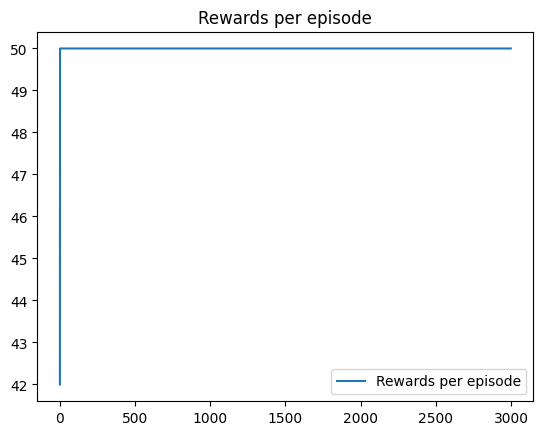

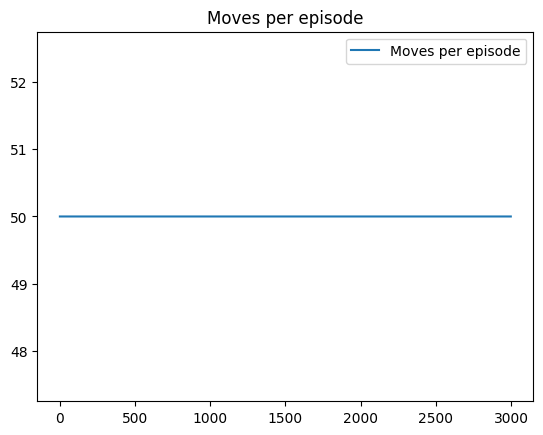

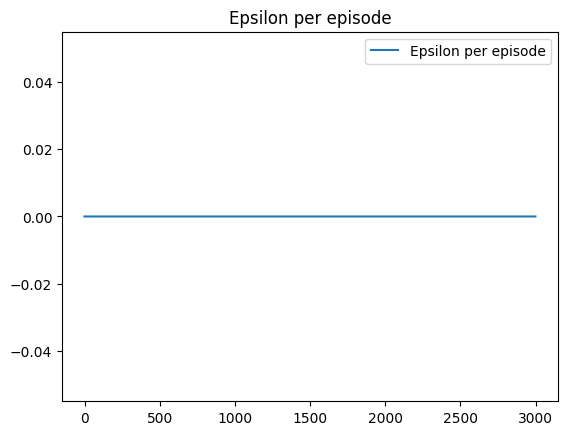

----------------------------------------------------
['X', 'X', 'X', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'X', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------


In [14]:

ql = qlearner(debug=False)
ql.run_q_learning(learning_rate=0.9, gamma=0.8, epsilon_decay_rate=1, episodes=3000,
                  max_steps=50, epsilon=0)


Run Q-learning with the following input parameters: (10)

1. learning_rate = 0.9, gamma = 0.8, epsilon_decay_rate = 0, episodes = 3000,
max_steps = 50, epsilon=1

2. Explain the 3 plots and the map generated. What is happening and why is
this happening?

Episode: 0 --- Epsilon: 1 --- Total Rewards: -98 --- Number of moves: 50 --- Last State: [3, 3]
Episode: 1 --- Epsilon: 1 --- Total Rewards: -22 --- Number of moves: 50 --- Last State: [9, 5]
Episode: 2 --- Epsilon: 1 --- Total Rewards: -66 --- Number of moves: 50 --- Last State: [4, 4]
Episode: 3 --- Epsilon: 1 --- Total Rewards: -38 --- Number of moves: 50 --- Last State: [2, 0]
Episode: 4 --- Epsilon: 1 --- Total Rewards: -112 --- Number of moves: 50 --- Last State: [4, 6]
Episode: 5 --- Epsilon: 1 --- Total Rewards: -195 --- Number of moves: 50 --- Last State: [8, 8]
Episode: 6 --- Epsilon: 1 --- Total Rewards: -176 --- Number of moves: 50 --- Last State: [2, 8]
Episode: 7 --- Epsilon: 1 --- Total Rewards: -246 --- Number of moves: 50 --- Last State: [5, 5]
Episode: 8 --- Epsilon: 1 --- Total Rewards: -338 --- Number of moves: 50 --- Last State: [6, 8]
Episode: 9 --- Epsilon: 1 --- Total Rewards: -242 --- Number of moves: 50 --- Last State: [1, 3]
Episode: 10 --- Epsilon: 1 --- Tot

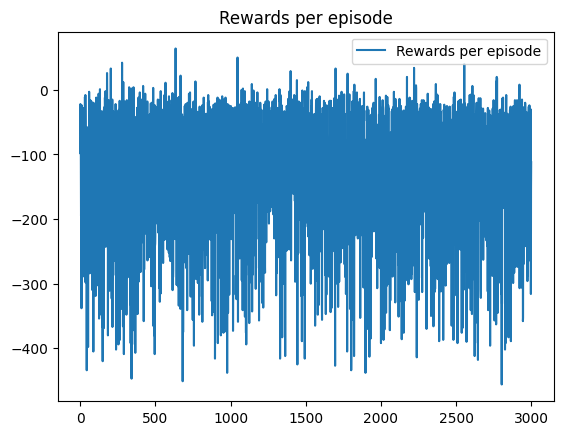

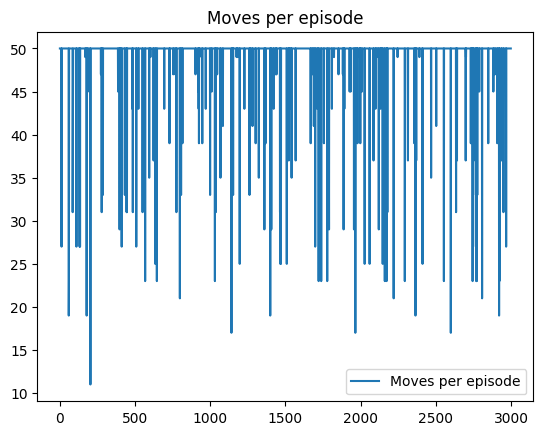

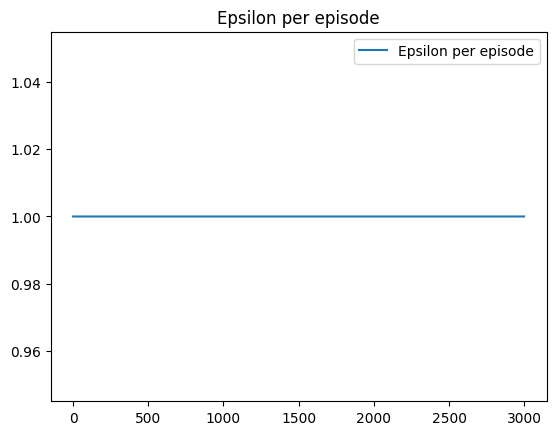

----------------------------------------------------
['X', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['X', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['X', 'X', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['X', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['X', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['X', 'X', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['X', 'X', 'X', 'X', 'O', 'O', 'O', 'O', 'O', 'O']
['X', 'X', 'X', 'X', 'O', 'O', 'O', 'O', 'O', 'O']
['X', 'X', 'X', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['X', 'X', 'X', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------


In [15]:
ql = qlearner(debug=False)
ql.run_q_learning(learning_rate=0.9, gamma=0.8, epsilon_decay_rate=0, episodes=3000,
                  max_steps=50, epsilon=1)

Run Q-learning using your own parameters to solve the above problem and help the
agent find the faster and most optimal path to the goal state. (10)

1. Explain the 3 plots and the map generated. What is happening and why is
this happening?

2. What is the total reward and number of moves of your discovered path?

3. Can you notice an alternative (but slower) path the agent could have taken to
increase the overall reward? If yes, why do you think it hasn’t taken that path?

Episode: 0 --- Epsilon: 1 --- Total Rewards: -408 --- Number of moves: 67 --- Last State: [0, 9]
Episode: 1 --- Epsilon: 0.999 --- Total Rewards: -208 --- Number of moves: 100 --- Last State: [2, 0]
Episode: 2 --- Epsilon: 0.998001 --- Total Rewards: -726 --- Number of moves: 100 --- Last State: [3, 3]
Episode: 3 --- Epsilon: 0.997002999 --- Total Rewards: -204 --- Number of moves: 100 --- Last State: [2, 6]
Episode: 4 --- Epsilon: 0.996005996001 --- Total Rewards: -247 --- Number of moves: 100 --- Last State: [4, 2]
Episode: 5 --- Epsilon: 0.995009990004999 --- Total Rewards: -258 --- Number of moves: 100 --- Last State: [0, 2]
Episode: 6 --- Epsilon: 0.994014980014994 --- Total Rewards: -608 --- Number of moves: 99 --- Last State: [0, 9]
Episode: 7 --- Epsilon: 0.993020965034979 --- Total Rewards: -509 --- Number of moves: 100 --- Last State: [1, 1]
Episode: 8 --- Epsilon: 0.9920279440699441 --- Total Rewards: -255 --- Number of moves: 100 --- Last State: [4, 4]
Episode: 9 --- Epsilo

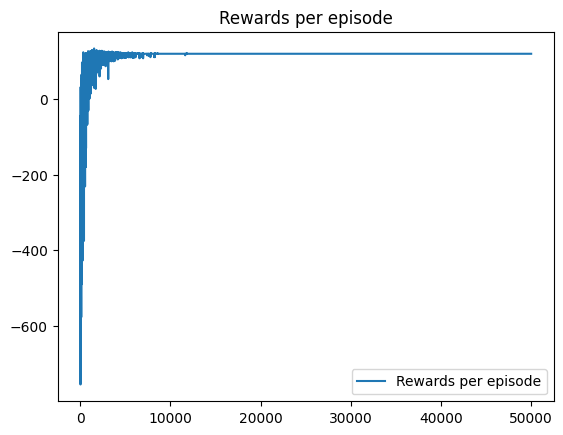

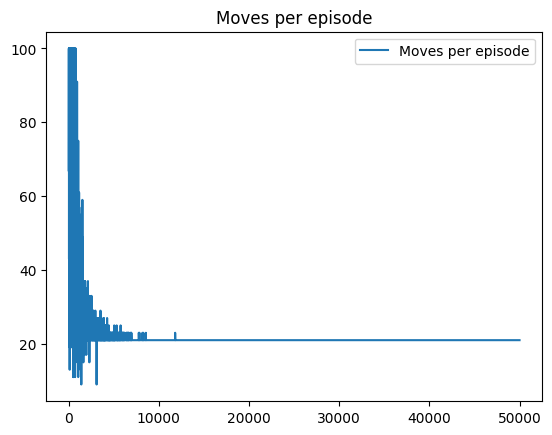

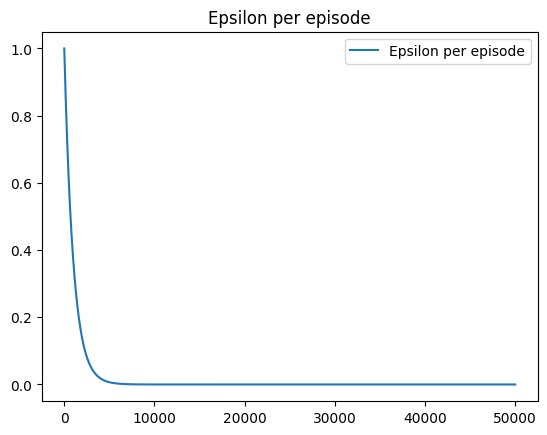

----------------------------------------------------
['X', 'X', 'X', 'O', 'O', 'O', 'O', 'O', 'X', 'X']
['O', 'O', 'X', 'O', 'O', 'O', 'O', 'O', 'X', 'O']
['O', 'O', 'X', 'O', 'O', 'O', 'O', 'O', 'X', 'O']
['O', 'O', 'X', 'X', 'X', 'O', 'O', 'O', 'X', 'O']
['O', 'O', 'O', 'O', 'X', 'O', 'O', 'O', 'X', 'O']
['O', 'O', 'O', 'O', 'X', 'O', 'O', 'O', 'X', 'O']
['O', 'O', 'O', 'O', 'X', 'X', 'X', 'X', 'X', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------


In [16]:
"""
so that based on the formula epsilon will be multiplied by 0.999 each time, the agent will become greedy 
Epsilon degrates over time. The lerning rate and gamma are set to 0.65 and the agent is
trained for  50000 episodes with 100 maximum steps as threshold.
"""
ql = qlearner(debug=False)
ql.run_q_learning(learning_rate=0.65, gamma=0.65, epsilon_decay_rate=0.001, episodes=50000,
                  max_steps=100, epsilon=1) 
